In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3" # set gpu number to use

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from tqdm import tqdm_notebook


In [2]:
batch_size = 64 # по какому количеству объектов выборки будем оценивать градиент 
anomaly_digit = 0 # какую цифру примем за аномалию

In [3]:
# Зададим обучающую и тестовую выборки в PyTorch

mnist_train = datasets.MNIST("../../../data/", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

mnist_test = datasets.MNIST("../../../data/", train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

class AnomalyWrapper(torch.utils.data.Dataset):
    def __init__(self, mnist_set, anomaly_digit, num_anomalies=None):
        self.data = torch.cat([i[0] for i in mnist_set], dim=0)
        real = mnist_set.targets != anomaly_digit
        if not num_anomalies:
            num_anomalies = (~real).sum()
        self.data = torch.cat([self.data[real], self.data[~real][:num_anomalies]], dim=0).unsqueeze(1)
        self.target = torch.cat([torch.ones(len(real)), torch.zeros(num_anomalies)], dim=0)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.target[index]
    
        


train_loader = torch.utils.data.DataLoader(AnomalyWrapper(mnist_train, anomaly_digit),
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(AnomalyWrapper(mnist_test, anomaly_digit),
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)


get_dset = lambda x: torch.utils.data.DataLoader(AnomalyWrapper(mnist_train, anomaly_digit, x),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                drop_last=True)



Label: 1.0


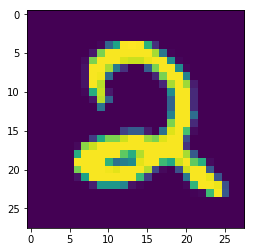

In [4]:
img, label = next(iter(train_loader)) # первый элемент обучающей выборки
print(f'Label: {label[0]}')
plt.imshow(img[0, 0,:,:])
plt.show()

# Baseline
В качестве бейслайна попробуем обучить бинарный классификатор (аномалия/не аномалия) в условиях малого количества аномалий

## Задание 1
Обучите бинарный классификатор для поиска аномалий. Посмотрите на финальный ROC AUC 

In [63]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(4*4*32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
# model = AlexNet(num_classes=1).cuda()

# criterion = nn.BCEWithLogitsLoss() 
# opt = torch.optim.Adam(model.parameters())


In [47]:
from sklearn.metrics import confusion_matrix

conf_metric = lambda labels, preds: confusion_matrix(labels, np.round(preds))

In [48]:
def train(loader):
    model.train()
    for j, (image,label) in tqdm_notebook(enumerate(loader), desc='train', leave=False):
        image, label = image.cuda(), label.cuda().float()
        opt.zero_grad()
        output = model(image).squeeze()
        loss = criterion(output, label)
        loss.backward()
        opt.step()

def evaluate(metric):
    model.eval()
    preds, labels = [], []
    for j, (image,label) in tqdm_notebook(enumerate(test_loader), desc='test', leave=False):
        image, label = image.cuda(), label.float()
        output = torch.sigmoid(model(image)).squeeze()
        preds.extend(output.detach().cpu().tolist())
        labels.extend(label.detach().tolist())
    return metric(labels, preds)

def train_eval(loader, num_epoch=10, metric=roc_auc_score):
    for epoch in range(num_epoch):
        train(loader)
    return evaluate(metric)



In [9]:
for num_anomalies in tqdm_notebook([10, 50, 100, 500, 1000, None]):
    dset = get_dset(num_anomalies)
    
    model = AlexNet(num_classes=1).cuda()

    criterion = nn.BCEWithLogitsLoss() 
    opt = torch.optim.Adam(model.parameters())

    metric = train_eval(dset, metric=conf_metric)
    print(f"Anomalies: {num_anomalies}, metric: \n{metric}")

Anomalies: 10, metric: 
[[ 294  682]
 [   0 9008]]


Anomalies: 50, metric: 
[[ 884   95]
 [   1 9004]]


Anomalies: 100, metric: 
[[ 786  192]
 [   0 9006]]


Anomalies: 500, metric: 
[[ 961   18]
 [   4 9001]]


Anomalies: 1000, metric: 
[[ 956   23]
 [   1 9004]]


Anomalies: None, metric: 
[[ 976    3]
 [  10 8995]]



In [10]:
for num_anomalies in tqdm_notebook([10, 50, 100, 500, 1000, None]):
    dset = get_dset(num_anomalies)
    
    model = AlexNet(num_classes=1).cuda()

    criterion = nn.BCEWithLogitsLoss() 
    opt = torch.optim.Adam(model.parameters())

    metric = train_eval(dset, metric=roc_auc_score)
    print(f"Anomalies: {num_anomalies}, metric: \n{metric}")

Anomalies: 10, metric: 
0.9860693667517592


Anomalies: 50, metric: 
0.9941510122485244


Anomalies: 100, metric: 
0.9907231806834526


Anomalies: 500, metric: 
0.9998347697043094


Anomalies: 1000, metric: 
0.9998542212485473


Anomalies: None, metric: 
0.9999819643949934



In [15]:
torch.sigmoid(torch.Tensor([-1]))

tensor([0.2689])

# AnoGAN

Основная идея [AnoGAN](https://arxiv.org/abs/1703.05921) - находить аномалии на основе расстояния до ближайшего соседа в пространстве латентных переменных. Алгоритм состоит из двух этапов:
1. На первом этапе обучается дискриминатор и генератор в стандартном режиме на нормальных объектах. При этом предполается, что генератор выучивает некоторое преобразование из латентного многообразия Z в пространство нормальных объектов
2. На втором этапе для каждого нового объекта считается расстояние до латентного многообразия, в котором сконцентрированы нормальные объекты. Те объекты, расстояние от которых до многообразия слишком большое, принимаются за аномалии

![](https://i.ibb.co/ZmzwMfS/image.png)

# AnoGAN. Этап 1. Обучение генератора на нормальных объектах

In [183]:
# Generator receives random noise z and create 1x28x28 image

class Generator(nn.Module):
    def __init__(self, input_shape=128):
        super(Generator,self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(input_shape, 16*7*7),
            nn.BatchNorm1d(16*7*7),
            nn.LeakyReLU(0.2),
        )
        
        self.layers = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), # 7x7
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'), # 14x14
            nn.Conv2d(32, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'), # 28x28
            nn.Conv2d(64, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, 1), # 1x28x28
            nn.Tanh()
        )

    def forward(self,z):
        z = self.fc(z).view(z.shape[0], 16, 7, 7)
        z = self.layers(z)
        return z

In [184]:
# Discriminator receives 1x28x28 image and returns a float number 0~1


class Discriminator(nn.Module):
    def __init__(self, num_classes=1):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(4*4*32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    


In [185]:
# Put class objects on Multiple GPUs using 
# torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
# device_ids: default all devices / output_device: default device 0 
# along with .cuda()

generator = Generator().cuda()
discriminator = Discriminator().cuda()

## Задание 2
Обучите GAN любым удобным вам способом

**Внимание:** обучайте GAN только на **нормальных** объектах (цифрах)!

In [222]:
# loss function, optimizers, and labels for training

criterion = nn.BCEWithLogitsLoss()
gen_optim = torch.optim.Adam(generator.parameters())
dis_optim = torch.optim.Adam(discriminator.parameters())

def image_check(gen_fake):
    img = gen_fake.data.numpy()
    plt.imshow(img[0][0])
    plt.show()

In [187]:
# model restore if any

try:
    generator.load_state_dict(torch.load('./saved_model/generator.pkl'))
    discriminator.load_state_dict(torch.load('./saved_model/discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass



--------model not restored--------



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0:0th iteration gen_loss: 0.7066072225570679 dis_loss: 1.4741837978363037
0:150th iteration gen_loss: 0.7676368951797485 dis_loss: 1.29347825050354
0:300th iteration gen_loss: 0.9807180762290955 dis_loss: 0.998954176902771
0:450th iteration gen_loss: 1.1477769613265991 dis_loss: 1.0155599117279053
0:600th iteration gen_loss: 1.0004938840866089 dis_loss: 1.2147324085235596
0:750th iteration gen_loss: 1.179717779159546 dis_loss: 1.081094741821289
0:900th iteration gen_loss: 1.441163182258606 dis_loss: 0.9306808114051819


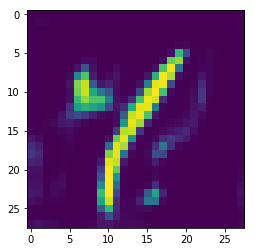

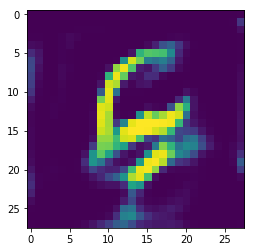

1:0th iteration gen_loss: 1.2730655670166016 dis_loss: 0.9489606618881226
1:150th iteration gen_loss: 2.0047764778137207 dis_loss: 0.8717010021209717
1:300th iteration gen_loss: 2.1567790508270264 dis_loss: 0.63165283203125
1:450th iteration gen_loss: 1.946291446685791 dis_loss: 0.7964249849319458
1:600th iteration gen_loss: 3.6754839420318604 dis_loss: 0.2809828221797943
1:750th iteration gen_loss: 2.9990360736846924 dis_loss: 0.43880730867385864
1:900th iteration gen_loss: 3.7067205905914307 dis_loss: 0.20719555020332336


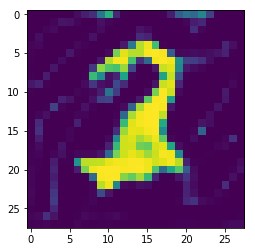

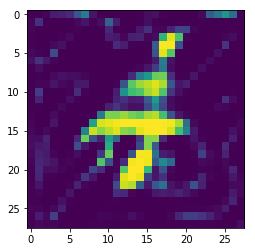

2:0th iteration gen_loss: 3.8629353046417236 dis_loss: 0.4548448920249939
2:150th iteration gen_loss: 5.145118236541748 dis_loss: 0.2722371816635132
2:300th iteration gen_loss: 3.626171350479126 dis_loss: 0.16550864279270172
2:450th iteration gen_loss: 3.1440589427948 dis_loss: 0.183542400598526
2:600th iteration gen_loss: 5.3702473640441895 dis_loss: 0.15629658102989197
2:750th iteration gen_loss: 3.482088088989258 dis_loss: 0.11347916722297668
2:900th iteration gen_loss: 4.689662933349609 dis_loss: 0.19206002354621887


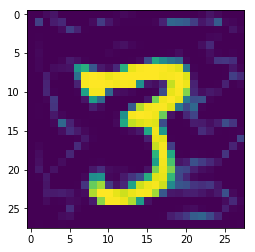

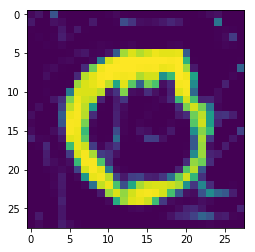

3:0th iteration gen_loss: 4.450433254241943 dis_loss: 0.16093125939369202
3:150th iteration gen_loss: 5.0406413078308105 dis_loss: 0.11742694675922394
3:300th iteration gen_loss: 5.907971382141113 dis_loss: 0.6010141372680664
3:450th iteration gen_loss: 7.151325702667236 dis_loss: 0.1958584487438202
3:600th iteration gen_loss: 4.302608966827393 dis_loss: 0.11551494151353836
3:750th iteration gen_loss: 7.013867378234863 dis_loss: 0.09487935900688171
3:900th iteration gen_loss: 6.216474533081055 dis_loss: 0.07681186497211456


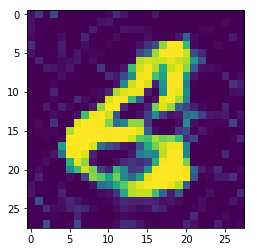

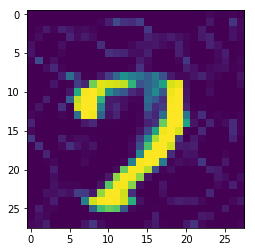

4:0th iteration gen_loss: 4.608282566070557 dis_loss: 0.26354387402534485
4:150th iteration gen_loss: 8.252029418945312 dis_loss: 0.06154434010386467
4:300th iteration gen_loss: 4.911397933959961 dis_loss: 0.08741394430398941
4:450th iteration gen_loss: 6.565439224243164 dis_loss: 0.06723076105117798
4:600th iteration gen_loss: 5.212706565856934 dis_loss: 0.05050211772322655
4:750th iteration gen_loss: 5.803412437438965 dis_loss: 0.10082300007343292
4:900th iteration gen_loss: 7.58009672164917 dis_loss: 0.028490619733929634


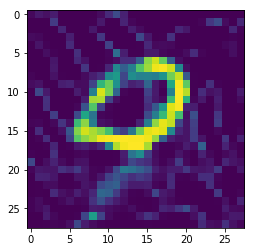

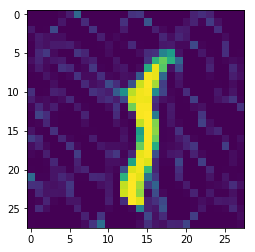

5:0th iteration gen_loss: 8.397510528564453 dis_loss: 0.07136277854442596
5:150th iteration gen_loss: 5.833723545074463 dis_loss: 0.10704487562179565
5:300th iteration gen_loss: 8.589338302612305 dis_loss: 0.02651696465909481
5:450th iteration gen_loss: 6.659635066986084 dis_loss: 0.05060760676860809
5:600th iteration gen_loss: 6.944849967956543 dis_loss: 0.1752258539199829
5:750th iteration gen_loss: 7.812829971313477 dis_loss: 0.26862969994544983
5:900th iteration gen_loss: 4.688684463500977 dis_loss: 0.1779319792985916


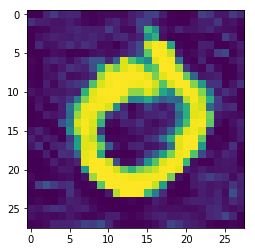

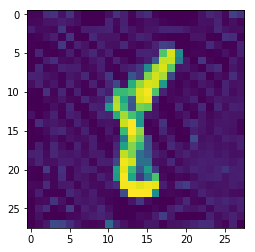

6:0th iteration gen_loss: 4.203305244445801 dis_loss: 0.17753960192203522
6:150th iteration gen_loss: 8.701231002807617 dis_loss: 0.37531718611717224
6:300th iteration gen_loss: 3.7154078483581543 dis_loss: 0.26672083139419556
6:450th iteration gen_loss: 3.0369603633880615 dis_loss: 0.16063763201236725
6:600th iteration gen_loss: 6.129312515258789 dis_loss: 0.7869960069656372
6:750th iteration gen_loss: 4.14921236038208 dis_loss: 0.3556597828865051
6:900th iteration gen_loss: 2.8612518310546875 dis_loss: 0.14725087583065033


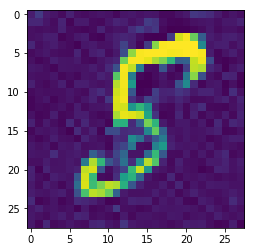

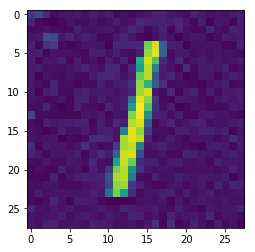

7:0th iteration gen_loss: 4.9507551193237305 dis_loss: 0.21428143978118896
7:150th iteration gen_loss: 3.1069345474243164 dis_loss: 0.4577498137950897
7:300th iteration gen_loss: 6.504676818847656 dis_loss: 0.17787252366542816
7:450th iteration gen_loss: 3.428605318069458 dis_loss: 0.2993621826171875
7:600th iteration gen_loss: 4.740569591522217 dis_loss: 0.2811383605003357
7:750th iteration gen_loss: 3.4776575565338135 dis_loss: 0.19960039854049683
7:900th iteration gen_loss: 2.6572530269622803 dis_loss: 0.2956311106681824


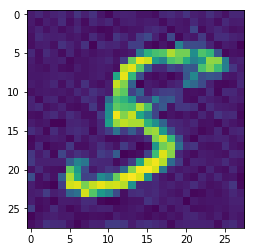

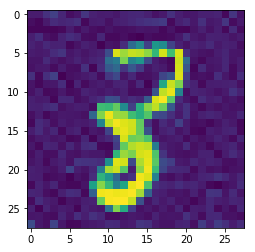

8:0th iteration gen_loss: 4.865068435668945 dis_loss: 0.12321877479553223
8:150th iteration gen_loss: 3.11441969871521 dis_loss: 0.3914013206958771
8:300th iteration gen_loss: 5.314897060394287 dis_loss: 0.23170281946659088
8:450th iteration gen_loss: 3.3906404972076416 dis_loss: 0.22050178050994873
8:600th iteration gen_loss: 5.6312255859375 dis_loss: 0.6075311303138733
8:750th iteration gen_loss: 2.2646307945251465 dis_loss: 0.15426377952098846
8:900th iteration gen_loss: 3.2302324771881104 dis_loss: 0.22800174355506897


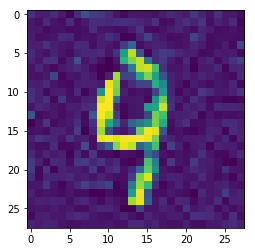

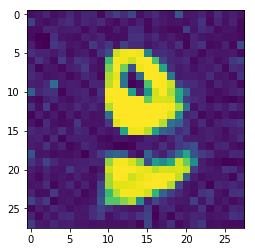

9:0th iteration gen_loss: 1.8391566276550293 dis_loss: 0.31841757893562317
9:150th iteration gen_loss: 3.5224344730377197 dis_loss: 0.11762725561857224
9:300th iteration gen_loss: 3.7171740531921387 dis_loss: 0.1026560515165329
9:450th iteration gen_loss: 6.343735218048096 dis_loss: 0.9564024806022644
9:600th iteration gen_loss: 4.969111919403076 dis_loss: 0.19321641325950623
9:750th iteration gen_loss: 3.1820273399353027 dis_loss: 0.7760055065155029
9:900th iteration gen_loss: 2.966564178466797 dis_loss: 0.2585866451263428


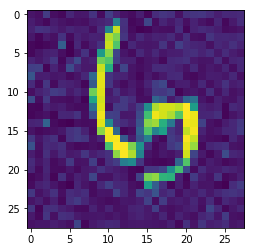

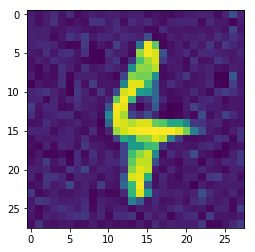

10:0th iteration gen_loss: 3.2707250118255615 dis_loss: 0.1968967765569687
10:150th iteration gen_loss: 3.0340545177459717 dis_loss: 0.28347280621528625
10:300th iteration gen_loss: 2.870112895965576 dis_loss: 0.3032759428024292
10:450th iteration gen_loss: 5.02610969543457 dis_loss: 0.38599032163619995
10:600th iteration gen_loss: 3.035973072052002 dis_loss: 0.1760558784008026
10:750th iteration gen_loss: 5.649488925933838 dis_loss: 0.6527398228645325
10:900th iteration gen_loss: 3.8601558208465576 dis_loss: 0.4131438434123993


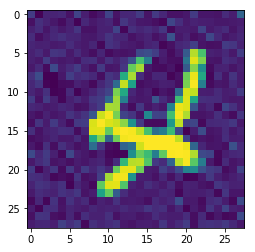

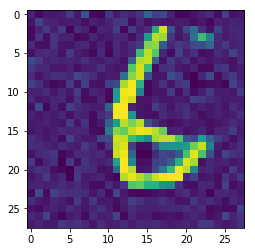

11:0th iteration gen_loss: 4.420949935913086 dis_loss: 0.2567718029022217
11:150th iteration gen_loss: 4.076943397521973 dis_loss: 0.10927277058362961
11:300th iteration gen_loss: 2.5891683101654053 dis_loss: 0.36285385489463806
11:450th iteration gen_loss: 3.9723949432373047 dis_loss: 0.2030160129070282
11:600th iteration gen_loss: 4.74671745300293 dis_loss: 0.45697104930877686
11:750th iteration gen_loss: 3.746811628341675 dis_loss: 0.251949667930603
11:900th iteration gen_loss: 5.595601558685303 dis_loss: 0.8057451248168945


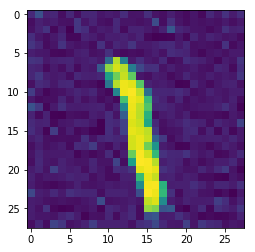

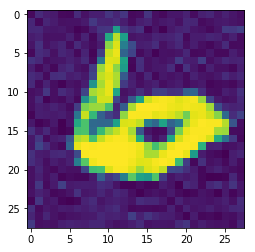

12:0th iteration gen_loss: 3.1504366397857666 dis_loss: 0.11009643971920013
12:150th iteration gen_loss: 2.839101552963257 dis_loss: 0.4392431676387787
12:300th iteration gen_loss: 2.6799981594085693 dis_loss: 0.18909446895122528
12:450th iteration gen_loss: 2.6899380683898926 dis_loss: 0.09854643046855927
12:600th iteration gen_loss: 3.462395429611206 dis_loss: 0.1246916651725769
12:750th iteration gen_loss: 2.4775867462158203 dis_loss: 0.07444775849580765
12:900th iteration gen_loss: 4.965785026550293 dis_loss: 0.22785581648349762


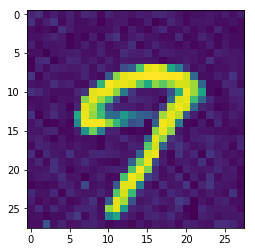

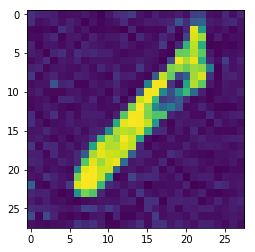

13:0th iteration gen_loss: 2.023883819580078 dis_loss: 0.22212345898151398
13:150th iteration gen_loss: 3.132953643798828 dis_loss: 0.11631070077419281
13:300th iteration gen_loss: 3.7718803882598877 dis_loss: 0.06413636356592178
13:450th iteration gen_loss: 3.076204299926758 dis_loss: 0.2160285860300064
13:600th iteration gen_loss: 5.27346134185791 dis_loss: 0.4448442757129669
13:750th iteration gen_loss: 2.6980161666870117 dis_loss: 0.5192613005638123
13:900th iteration gen_loss: 3.728306770324707 dis_loss: 1.4494467973709106


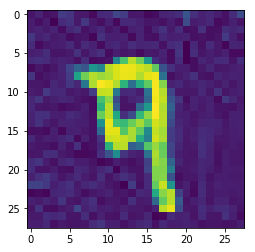

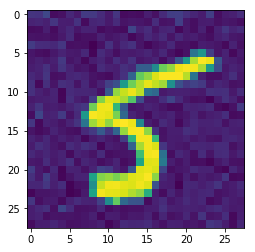

14:0th iteration gen_loss: 2.0602970123291016 dis_loss: 0.2097029685974121
14:150th iteration gen_loss: 2.3783175945281982 dis_loss: 0.19725708663463593
14:300th iteration gen_loss: 3.0418641567230225 dis_loss: 0.44254523515701294
14:450th iteration gen_loss: 4.768287181854248 dis_loss: 0.306846559047699
14:600th iteration gen_loss: 2.3902225494384766 dis_loss: 0.09830983728170395
14:750th iteration gen_loss: 4.181328773498535 dis_loss: 0.9358054995536804
14:900th iteration gen_loss: 4.366755962371826 dis_loss: 0.17504540085792542


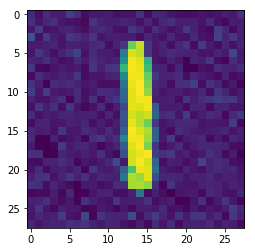

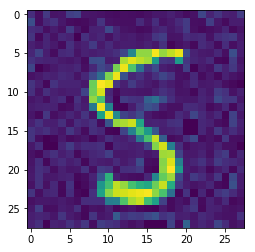

15:0th iteration gen_loss: 3.42436146736145 dis_loss: 0.38834330439567566
15:150th iteration gen_loss: 2.770395278930664 dis_loss: 0.9526898860931396
15:300th iteration gen_loss: 5.107982635498047 dis_loss: 1.8009767532348633
15:450th iteration gen_loss: 3.473191976547241 dis_loss: 0.1403953731060028
15:600th iteration gen_loss: 1.4518580436706543 dis_loss: 0.35263293981552124
15:750th iteration gen_loss: 4.151831150054932 dis_loss: 0.2104206085205078
15:900th iteration gen_loss: 3.368077516555786 dis_loss: 1.0066238641738892


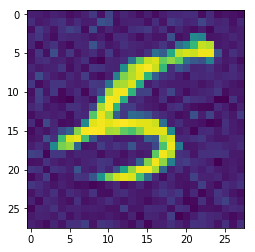

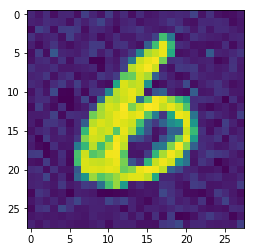

16:0th iteration gen_loss: 5.43004035949707 dis_loss: 0.31415122747421265
16:150th iteration gen_loss: 3.3023386001586914 dis_loss: 0.35423511266708374
16:300th iteration gen_loss: 3.4246716499328613 dis_loss: 0.12290021032094955
16:450th iteration gen_loss: 3.4117963314056396 dis_loss: 0.10971441864967346
16:600th iteration gen_loss: 2.56290602684021 dis_loss: 0.2977072298526764
16:750th iteration gen_loss: 2.0387463569641113 dis_loss: 0.48411548137664795
16:900th iteration gen_loss: 1.4931581020355225 dis_loss: 0.4060722589492798


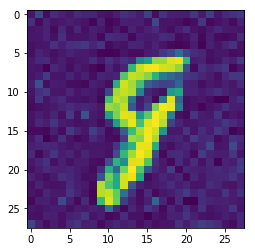

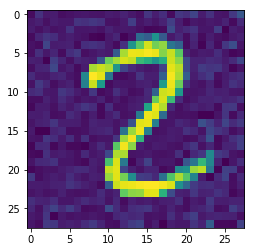

17:0th iteration gen_loss: 4.212235927581787 dis_loss: 0.10044710338115692
17:150th iteration gen_loss: 0.7852727770805359 dis_loss: 0.15936517715454102
17:300th iteration gen_loss: 3.1465542316436768 dis_loss: 0.18557089567184448
17:450th iteration gen_loss: 5.760898113250732 dis_loss: 0.39926889538764954
17:600th iteration gen_loss: 4.0094380378723145 dis_loss: 0.6661782264709473
17:750th iteration gen_loss: 4.2003068923950195 dis_loss: 0.19582369923591614
17:900th iteration gen_loss: 3.124840259552002 dis_loss: 0.1585400402545929


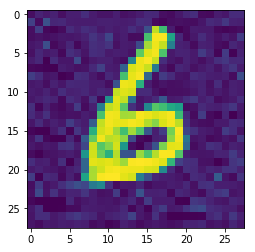

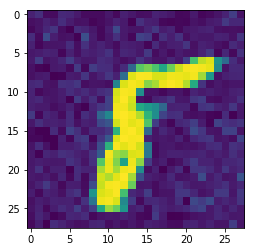

18:0th iteration gen_loss: 4.699589252471924 dis_loss: 0.30163681507110596
18:150th iteration gen_loss: 3.0829994678497314 dis_loss: 0.09573694318532944
18:300th iteration gen_loss: 4.392529487609863 dis_loss: 0.27212196588516235
18:450th iteration gen_loss: 4.040287971496582 dis_loss: 0.18124544620513916
18:600th iteration gen_loss: 4.1784892082214355 dis_loss: 0.8820170760154724
18:750th iteration gen_loss: 4.274057388305664 dis_loss: 0.35625892877578735
18:900th iteration gen_loss: 4.132083892822266 dis_loss: 0.33739104866981506


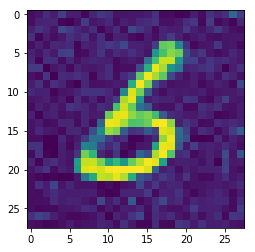

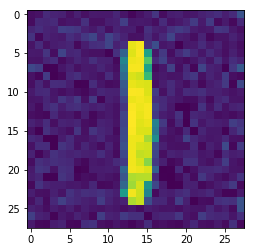

19:0th iteration gen_loss: 3.01941180229187 dis_loss: 0.16366975009441376
19:150th iteration gen_loss: 3.226269006729126 dis_loss: 0.11997614800930023
19:300th iteration gen_loss: 4.08079195022583 dis_loss: 0.5991044044494629
19:450th iteration gen_loss: 4.009866237640381 dis_loss: 0.08992687612771988
19:600th iteration gen_loss: 3.4522347450256348 dis_loss: 0.4510137140750885
19:750th iteration gen_loss: 3.4303107261657715 dis_loss: 0.3028697669506073
19:900th iteration gen_loss: 4.776478290557861 dis_loss: 0.29421666264533997


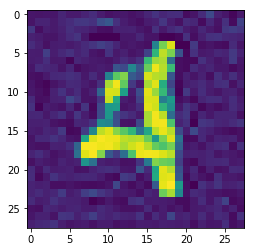

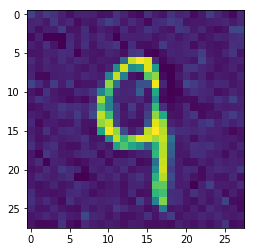

In [189]:
# train
num_epochs = 20

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    for j, (image,label) in tqdm_notebook(enumerate(train_loader), leave=False):
        image = image.cuda()
        
        image = image[label == 1].cuda() # оставляем для обучения только нормальные объекты
        
        batch_size = image.shape[0]
        ones_label = torch.ones(batch_size, 1).cuda()
        zeros_label = torch.zeros(batch_size, 1).cuda()

        # generator
        gen_optim.zero_grad()
        
        z = Variable(nn.init.normal_(torch.Tensor(batch_size, 128), mean=0, std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
    
        gen_loss = criterion(dis_fake, ones_label) # fake classified as real
        gen_loss.backward()
#         nn.utils.clip_grad_norm_(generator.parameters(), 1)
        gen_optim.step()
    
        # discriminator
        
        dis_optim.zero_grad()
        
        z = Variable(nn.init.normal_(torch.Tensor(batch_size, 128), mean=0, std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        image_noised = image + nn.init.normal_(torch.Tensor(*image.shape), mean=0, std=0.1).cuda()
        dis_real = discriminator.forward(image_noised)
        dis_loss = criterion(dis_fake, zeros_label) + criterion(dis_real, ones_label)
        dis_loss.backward()
#         nn.utils.clip_grad_norm_(discriminator.parameters(), 1)
        dis_optim.step()
    
        # model save
        if j % 150 == 0:
#             torch.save(generator.state_dict(),'./saved_model/generator.pkl')
#             torch.save(discriminator.state_dict(),'./saved_model/discriminator.pkl')
            print(f"{epoch}:{j}th iteration gen_loss: {gen_loss.item()} dis_loss: {dis_loss.item()}")  
    generator.eval()
    discriminator.eval()

    image_check(gen_fake.cpu())
    

## AnoGAN. Этап 2. Подсчёт расстояния до нормальных объектов и подбор 

## Задание 3
Реализуйте расстояние до аномалий согласно формуле, предложенной в [статье](https://arxiv.org/abs/1703.05921):
$$L(x,G_z)=(1-\lambda)|x-G_z| + \lambda|D(x)-D(G_z)|$$

In [198]:
discriminator

Discriminator(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

In [206]:
def get_features(x):
    x = discriminator.features(x)
    x = x.view(x.size(0), -1)
    for module in discriminator.classifier[:-1]:
        x = module(x)
    return x

In [210]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x, G_z, Lambda=0.1): # расстояние до аномалии x до ближайшего соседа G_z
    x_feature = get_features(x)
    G_z_feature = get_features(G_z)
    
    residual_loss = torch.sum(torch.abs(x - G_z), dim=[1,2,3])
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature), 1)
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    return total_loss

In [237]:
eval_loader = torch.utils.data.DataLoader(AnomalyWrapper(mnist_test, anomaly_digit),
                                           batch_size=5000,
                                           shuffle=True,
                                           drop_last=False)



Label: 1.0


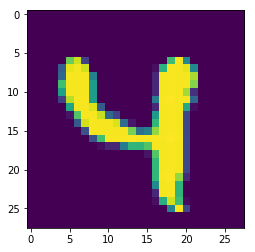

In [238]:
x, y = next(iter(eval_loader))
print(f'Label: {y[0]}')
plt.imshow(x[0, 0,:,:])
plt.show()

In [239]:
z = Variable(init.normal_(torch.zeros(batch_size, 128), mean=0, std=0.1), requires_grad=True)
z_optimizer = torch.optim.Adam([z], lr=1e-4)

gen_fake = generator(z.cuda())

loss = Anomaly_score(x.cuda(), gen_fake)
print(loss.shape)
print(loss.mean())


image_check(x.cpu())
image_check(gen_fake.cpu())


RuntimeError: CUDA out of memory. Tried to allocate 958.00 MiB (GPU 0; 11.17 GiB total capacity; 1.29 GiB already allocated; 817.75 MiB free; 81.55 MiB cached)

## Задание 4
Используя оптимизатор выше, найдите ближайших соседей z для выборки train_data_mnist. Посмотрите, как по мере обучения меняется расстояние и ROC AUC. Сравните результат с baseline. Стало ли лучше?

In [226]:
from sklearn.metrics import roc_auc_score

for i in range(10000):
    gen_fake = generator(z.cuda())
    dist = Anomaly_score(x.cuda(), gen_fake, Lambda=0.01)
    dist.mean().backward() # минимизируем расстояние до нормального соседа
    z_optimizer.step() # обновляем ближайшего нормального соседа (z) для каждого объекта 
    if i%100==0:
        print(f'Dist: {dist.mean().cpu().data}')
        
#         target = test_data_mnist[1,0,:,:].numpy()
#         plt.imshow(target,cmap="gray")
#         plt.show()
        
#         img=gen_fake.cpu().data[1,0,:,:].numpy()
#         plt.imshow(img,cmap='gray')
#         plt.show()


Dist: 248.57472229003906
Dist: 247.4346466064453
Dist: 247.12132263183594
Dist: 245.93519592285156
Dist: 231.80226135253906
Dist: 230.72950744628906
Dist: 229.68890380859375
Dist: 229.34153747558594
Dist: 228.87393188476562
Dist: 226.98471069335938
Dist: 227.7294158935547
Dist: 227.05137634277344
Dist: 225.97561645507812
Dist: 226.0089569091797
Dist: 225.0254669189453
Dist: 224.19290161132812
Dist: 224.85186767578125
Dist: 223.36093139648438
Dist: 223.06492614746094
Dist: 222.7560577392578
Dist: 222.5558319091797
Dist: 221.2431182861328
Dist: 220.58663940429688
Dist: 221.3031463623047
Dist: 219.0557861328125
Dist: 218.8725128173828
Dist: 218.04905700683594
Dist: 217.68841552734375
Dist: 217.88519287109375
Dist: 216.4900665283203
Dist: 216.99417114257812
Dist: 216.46177673339844
Dist: 215.9908905029297
Dist: 215.49343872070312
Dist: 215.0941925048828
Dist: 214.3714599609375
Dist: 213.98182678222656
Dist: 213.38722229003906
Dist: 212.4529571533203
Dist: 212.62582397460938
Dist: 211.37327

## Задание 5
Посмотрим на ближайших соседей

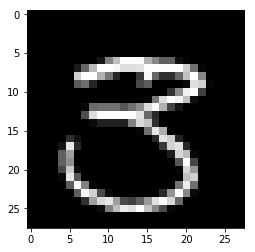

real data


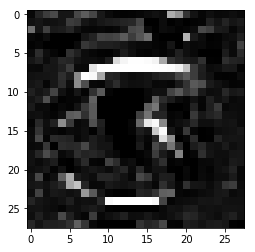

nearest neighbour

------------------------------------



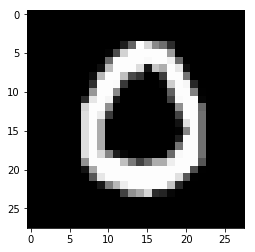

real data


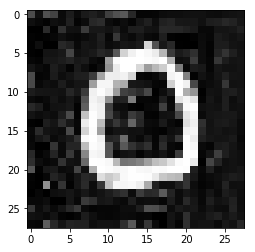

nearest neighbour

------------------------------------



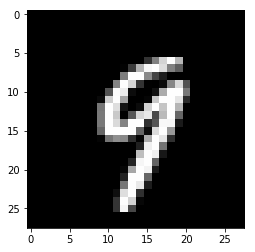

real data


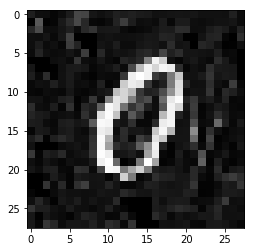

nearest neighbour

------------------------------------



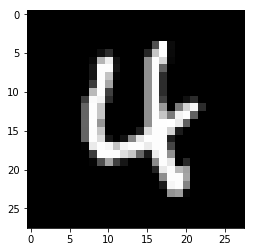

real data


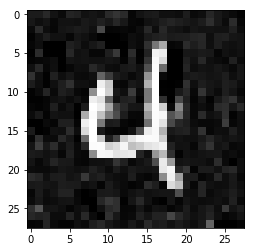

nearest neighbour

------------------------------------



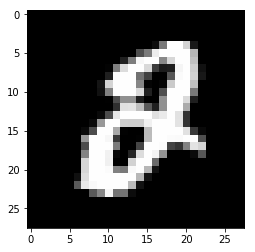

real data


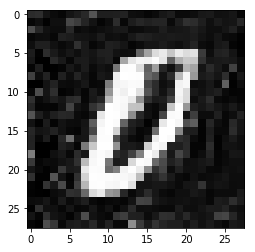

nearest neighbour

------------------------------------



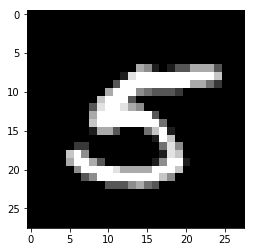

real data


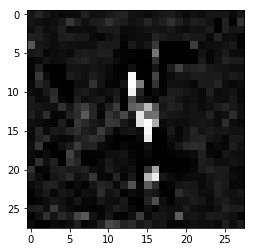

nearest neighbour

------------------------------------



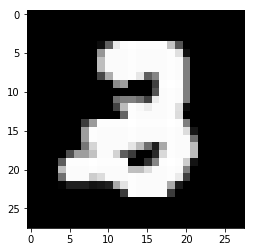

real data


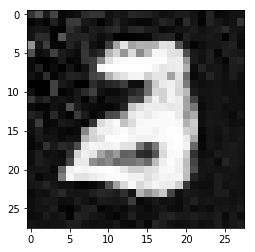

nearest neighbour

------------------------------------



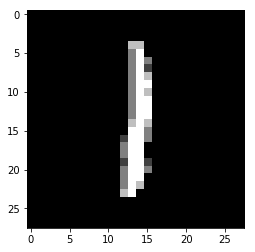

real data


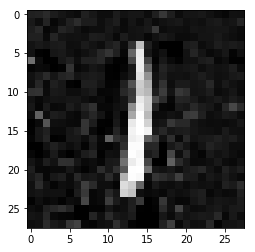

nearest neighbour

------------------------------------



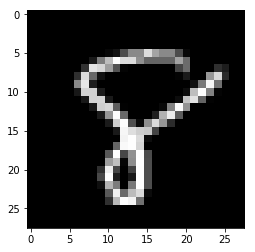

real data


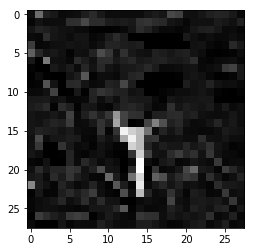

nearest neighbour

------------------------------------



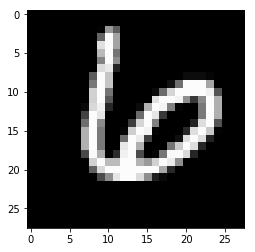

real data


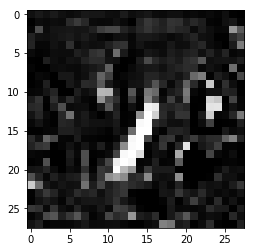

nearest neighbour

------------------------------------



In [228]:
for idx in range(10):
    plt.imshow(x[idx,0,:,:].numpy(),
               cmap="gray")
    plt.show()
    print("real data")

    plt.imshow(gen_fake.cpu().data[idx,0,:,:].numpy(),
               cmap='gray')
    plt.show()
    print("nearest neighbour")
    print("\n------------------------------------\n")

## Задание 6
Построим распределение расстояний для нормальных и аномальных объектов.
Что можно сказать, глядя на это распределение?

In [229]:
%matplotlib inline
import seaborn as sns
sns.distplot(loss[y].detach().cpu().numpy(), label='anomalies')
sns.distplot(loss[~y].detach().cpu().numpy(), label='non-anomalies')
plt.xlabel('distance')
plt.legend()

IndexError: tensors used as indices must be long, byte or bool tensors

In [230]:
y

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.])

## Задание 7 (*)
Попробуйте обучить baseline (классификатор) на большем количестве аномалий. Стал ли классификатор работать лучше AnoGAN и, если да, с какого момента?